<a href="https://colab.research.google.com/github/SolanaO/Customer_Churn_Prediction/blob/master/KG_Covid19_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminaries

## Workspace Setup

As given in the JSL Colab notebooks.

In [1]:
import json
import os

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

Saving spark_nlp_for_healthcare_spark_ocr_5320.json to spark_nlp_for_healthcare_spark_ocr_5320.json


In [2]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

     |████████████████████████████████| 212.4 MB 68 kB/s 
     |████████████████████████████████| 145 kB 65.4 MB/s 
     |████████████████████████████████| 198 kB 73.5 MB/s 
     |████████████████████████████████| 151 kB 6.3 MB/s 
     |████████████████████████████████| 95 kB 2.3 MB/s 
     |████████████████████████████████| 66 kB 4.8 MB/s 


In [3]:
import time
from tqdm import tqdm

import functools 
import numpy as np
import pandas as pd
from scipy import spatial

import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession

params = {"spark.driver.memory":"26G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark

Spark NLP Version : 3.4.4
Spark NLP_JSL Version : 3.5.2


In [4]:
!pip install neo4j
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 3.7 MB/s 
  Created wheel for neo4j: filename=neo4j-4.4.4-py3-none-any.whl size=116554 sha256=2ba163006719b6c76cd77d46d3675ac78b58f79d22eb6b3b2acb95bfeefa19b9
  Stored in directory: /root/.cache/pip/wheels/cf/c9/60/dab99fdca0093b46a9c9f5d5b99317c9d323c97d2f5af24e23
Successfully built neo4j
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Import packages for neo4j 
from neo4j import GraphDatabase

## Data Upload

In [6]:
# Importing the metadata file
!wget -q https://raw.githubusercontent.com/SolanaO/Knowledge_Graphs_Covid19/master/one_author.csv
# Save as a pandas dataframe
metadata_df = pd.read_csv("one_author.csv", index_col=0)
# Inspect the data
metadata_df.head(2)

,title,abstract,author,journal,index
2,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...,"Crouch, Erika C",Respir Res,1
13,Discovering human history from stomach bacteria,Recent analyses of human pathogens have reveal...,"Disotell, Todd R",Genome Biol,2


In [7]:
# Inspect the data shape
metadata_df.shape

(8088, 5)

# The NER-RE Pipeline

In [8]:
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence_detector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentences")

tokenizer = Tokenizer()\
    .setInputCols(["sentences"])\
    .setOutputCol("tokens")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("embeddings")

pos_tagger = PerceptronModel() \
    .pretrained("pos_clinical", "en", "clinical/models")\
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("pos_tags")

events_admission_ner_tagger = MedicalNerModel()\
    .pretrained("ner_events_admission_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")   

ner_chunker = NerConverterInternal()\
    .setInputCols(["sentences", "tokens", "ner_tags"])\
    .setOutputCol("ner_chunks")

dependency_parser = DependencyParserModel()\
    .pretrained("dependency_conllu", "en")\
    .setInputCols(["sentences", "pos_tags", "tokens"])\
    .setOutputCol("dependencies")

events_reModel = RelationExtractionModel()\
    .pretrained("re_temporal_events_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("events_relations")\
    .setMaxSyntacticDistance(4)\
    .setPredictionThreshold(0.9)

clinical_ner_large = MedicalNerModel.pretrained("ner_clinical_large", "en", "clinical/models") \
    .setInputCols(["sentences", "tokens", "embeddings"]) \
    .setOutputCol("ner_clinical")\

clinical_ner_converter = NerConverterInternal() \
    .setInputCols(["sentences", "tokens", "ner_clinical"]) \
    .setOutputCol("clinical_ner_chunks")

clinical_re = RelationExtractionModel()\
    .pretrained("re_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "clinical_ner_chunks", "dependencies"])\
    .setOutputCol("clinical_relations") \
    .setMaxSyntacticDistance(4)\
    .setPredictionThreshold(0.9)

annotation_merger = AnnotationMerger()\
    .setInputCols("clinical_relations", "events_relations")\
    .setInputType("category")\
    .setOutputCol("all_relations")

merger_pipe = Pipeline(stages=[
document_assembler,
sentence_detector,
tokenizer,
word_embeddings,
pos_tagger,
events_admission_ner_tagger,
ner_chunker,
dependency_parser,
events_reModel,
clinical_ner_large,
clinical_ner_converter,
clinical_re,
annotation_merger
])

empty_df= spark.createDataFrame([[""]]).toDF("text")
merger_model= merger_pipe.fit(empty_df)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
ner_events_admission_clinical download started this may take some time.
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]
re_temporal_events_clinical download started this may take some time.
Approximate size to download 5.9 MB
[OK!]
ner_clinical_large download started this may take some time.
[OK!]
re_clinical download started this may take some time.
Approximate size to download 6 MB
[OK!]


# Results with the LightPipeline

In [9]:
# Sample text
text = '''
Heme oxygenase-1 (HO-1), an inducible stress protein, confers cytoprotection against oxidative stress in vitro and in vivo.
In addition to its physiological role in heme degradation, HO-1 may influence a number of cellular processes, including growth, inflammation, and apoptosis.
By virtue of anti-inflammatory effects, HO-1 limits tissue damage in response to proinflammatory stimuli and prevents allograft rejection after transplantation.
The transcriptional upregulation of HO-1 responds to many agents, such as hypoxia, bacterial lipopolysaccharide, and reactive oxygen/nitrogen species.
'''

In [10]:
# Transform the text sample
data = spark.createDataFrame([[text]]).toDF("text")

# Get the result on the text sample
result = merger_model.transform(data)
result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|           sentences|              tokens|          embeddings|            pos_tags|            ner_tags|          ner_chunks|        dependencies|    events_relations|        ner_clinical| clinical_ner_chunks|  clinical_relations|       all_relations|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|
Heme oxygenase-1...|[{document, 0, 59...|[{document, 1, 12...|[{token, 1, 4, He...|[{word_embeddings...|[{pos,

In [11]:
result_df = result.select(F.explode(F.arrays_zip('events_relations.result', 'events_relations.metadata',
                                                 'clinical_relations.result', 'clinical_relations.metadata',
                                                 'all_relations.result', 'all_relations.metadata')).alias("cols")) \
                  .select(
                          F.expr("cols['0']").alias("events_relations"),\
                          F.expr("cols['1']['entity1']").alias("events_relations_entity1"),\
                          F.expr("cols['1']['chunk1']" ).alias("events_relations_chunk1" ),\
                          F.expr("cols['1']['entity2']").alias("events_relations_entity2"),\
                          F.expr("cols['1']['chunk2']" ).alias("events_relations_chunk2" ),\
                          F.expr("cols['2']").alias("clinical_relations"),\
                          F.expr("cols['3']['entity1']").alias("clinical_relations_entity1"),\
                          F.expr("cols['3']['chunk1']" ).alias("clinical_relations_chunk1" ),\
                          F.expr("cols['3']['entity2']").alias("clinical_relations_entity2"),\
                          F.expr("cols['3']['chunk2']" ).alias("clinical_relations_chunk2" ),\
                          F.expr("cols['4']").alias("all_relations"),\
                          F.expr("cols['5']['entity1']").alias("all_relations_entity1"),\
                          F.expr("cols['5']['chunk1']" ).alias("all_relations_chunk1" ),\
                          F.expr("cols['5']['entity2']").alias("all_relations_entity2"),\
                          F.expr("cols['5']['chunk2']" ).alias("all_relations_chunk2" )
                          )

result_df.show()

+----------------+------------------------+-----------------------+------------------------+-----------------------+------------------+--------------------------+-------------------------+--------------------------+-------------------------+-------------+---------------------+--------------------+---------------------+--------------------+
|events_relations|events_relations_entity1|events_relations_chunk1|events_relations_entity2|events_relations_chunk2|clinical_relations|clinical_relations_entity1|clinical_relations_chunk1|clinical_relations_entity2|clinical_relations_chunk2|all_relations|all_relations_entity1|all_relations_chunk1|all_relations_entity2|all_relations_chunk2|
+----------------+------------------------+-----------------------+------------------------+-----------------------+------------------+--------------------------+-------------------------+--------------------------+-------------------------+-------------+---------------------+--------------------+------------------

In [12]:
# Build a LightPipeline and visualize the results
light_merger = LightPipeline(merger_model)
light_result = light_merger.fullAnnotate(text)[0]

In [13]:
from sparknlp_display import RelationExtractionVisualizer

In [14]:
vis= RelationExtractionVisualizer()
vis.display(light_result, 'all_relations', show_relations=True)

/usr/local/lib/python3.7/dist-packages/sparknlp_display/relation_extraction.py:366: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  relation_coordinates = np.array(relation_coordinates)


In [15]:
# Function to extract the relevant columns as pandas dataframe
def get_relations_df (results, col):
  rel_pairs=[]
  for rel in results[0][col]:
      rel_pairs.append((
          rel.result, 
          rel.metadata['entity1'], 
          rel.metadata['entity1_begin'],
          rel.metadata['entity1_end'],
          rel.metadata['chunk1'], 
          rel.metadata['entity2'],
          rel.metadata['entity2_begin'],
          rel.metadata['entity2_end'],
          rel.metadata['chunk2'], 
          rel.metadata['confidence']
      ))

  rel_df = pd.DataFrame(rel_pairs, columns=['relation',
                                            'entity1','entity1_begin',
                                            'entity1_end','chunk1',
                                            'entity2','entity2_begin',
                                            'entity2_end','chunk2', 
                                            'confidence'])

  return rel_df


In [16]:
lr = light_merger.fullAnnotate(text)
rel_df = get_relations_df(lr, 'all_relations')
rel_df = rel_df[(rel_df.relation!="O")]
rel_df

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
1,TeRP,TREATMENT,63,76,cytoprotection,PROBLEM,86,110,oxidative stress in vitro,0.9954646
2,PIP,PROBLEM,215,232,cellular processes,PROBLEM,245,250,growth,0.99999857
3,PIP,PROBLEM,215,232,cellular processes,PROBLEM,253,264,inflammation,0.98734343
4,PIP,PROBLEM,245,250,growth,PROBLEM,253,264,inflammation,0.99932134
5,PIP,PROBLEM,245,250,growth,PROBLEM,271,279,apoptosis,0.99999976
6,PIP,PROBLEM,253,264,inflammation,PROBLEM,271,279,apoptosis,1.0
7,TeRP,TREATMENT,295,319,anti-inflammatory effects,PROBLEM,322,346,HO-1 limits tissue damage,0.99959785
8,TeRP,PROBLEM,322,346,HO-1 limits tissue damage,TEST,363,385,proinflammatory stimuli,0.9615016
9,TeRP,TEST,363,385,proinflammatory stimuli,PROBLEM,400,418,allograft rejection,1.0
10,TeRP,TEST,363,385,proinflammatory stimuli,TREATMENT,426,440,transplantation,0.99999225


## Neo4j Connection for LightPipeline

In [17]:
!pip install neo4j
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
from neo4j import GraphDatabase
import time
from tqdm import tqdm

### Helper Functions

In [19]:
# Source: https://medium.com/spark-nlp/creating-knowledge-graph-by-spark-nlp-neo4j

class Neo4jConnection:
    '''
    Helper class to establish connection with the Sandbox database. 
    '''
    
    def __init__(self, uri, user, pwd):
        
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        
        try:
            self.__driver = GraphDatabase.driver(self.__uri, 
                                                 auth=(self.__user, 
                                                       self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [20]:
# Source: https://medium.com/spark-nlp/creating-knowledge-graph-by-spark-nlp-neo4j

def update_data(query, rows, batch_size = 1000):
    # Function to handle the updating the Neo4j database in batch mode.
    # Especially for large datasets.
    total = 0
    batch = 0
    start = time.time()
    result = None

    while batch * batch_size < len(rows):

        res = conn.query(query, 
                         parameters={'rows': rows[batch*batch_size:(batch+1)*batch_size].to_dict('records')})
        total += res[0]['total']
        batch += 1
        result = {"total":total, "batches":batch, "time":time.time()-start}
        print(result)

    return result

In [21]:
def add_ners_rels(rows, batch_size=10000):
    # Adds NER nodes to the Neo4j graph as a batch job.
    query = '''
    //chunk1 NERs
    UNWIND $rows as row
    MERGE(n1:NER{name:row.chunk1}) ON CREATE SET n1.type=row.entity1
    
    //chunk2 NERs
    MERGE(n2:NER{name:row.chunk2}) ON CREATE SET n2.type=row.entity2

    //connect NERs
    WITH row, n1, n2
    MERGE (n1)-[:LINKS{relation:row.relation}]->(n2)

    WITH n1
    MATCH (n1)
    RETURN count(*) as total  
    '''

    return update_data(query, rows, batch_size)

In [22]:
# Provide credentials - from Sandbox page - and initiate the connection
uri = 'bolt://44.201.183.12:7687'
pwd = 'fault-fact-whistles'
user= 'neo4j'

conn = Neo4jConnection(uri=uri, user=user , pwd=pwd)

Input queries in the browser Sandbox window to visualize the results.

**Important Note**: Before run any Neo4j query, you should delete all nodes and relationships.

In [23]:
delete_all_nodes_vers1= 'MATCH (n) DETACH DELETE n;'
conn.query(delete_all_nodes_vers1)

[]

In [24]:
delete_all_nodes = '''
MATCH (n) WITH n LIMIT 10000
DETACH DELETE n RETURN count(*)
'''
conn.query(delete_all_nodes)

[<Record count(*)=0>]

Create constraints within the database that will ensure the nodes are not duplicates and also set some indexing.

In [25]:
const_ners = 'CREATE CONSTRAINT ners IF NOT EXISTS ON (n:NER) ASSERT n.name IS UNIQUE'
conn.query(const_ners)

[]

### Neo4j Graph for Sample Text

In [26]:
# Upload relations and nodes
add_ners_rels(rel_df)

{'total': 27, 'batches': 1, 'time': 0.05504918098449707}


{'batches': 1, 'time': 0.05504918098449707, 'total': 27}

In [27]:
query = 'MATCH (p)-[r]-(n) RETURN p,r,n'

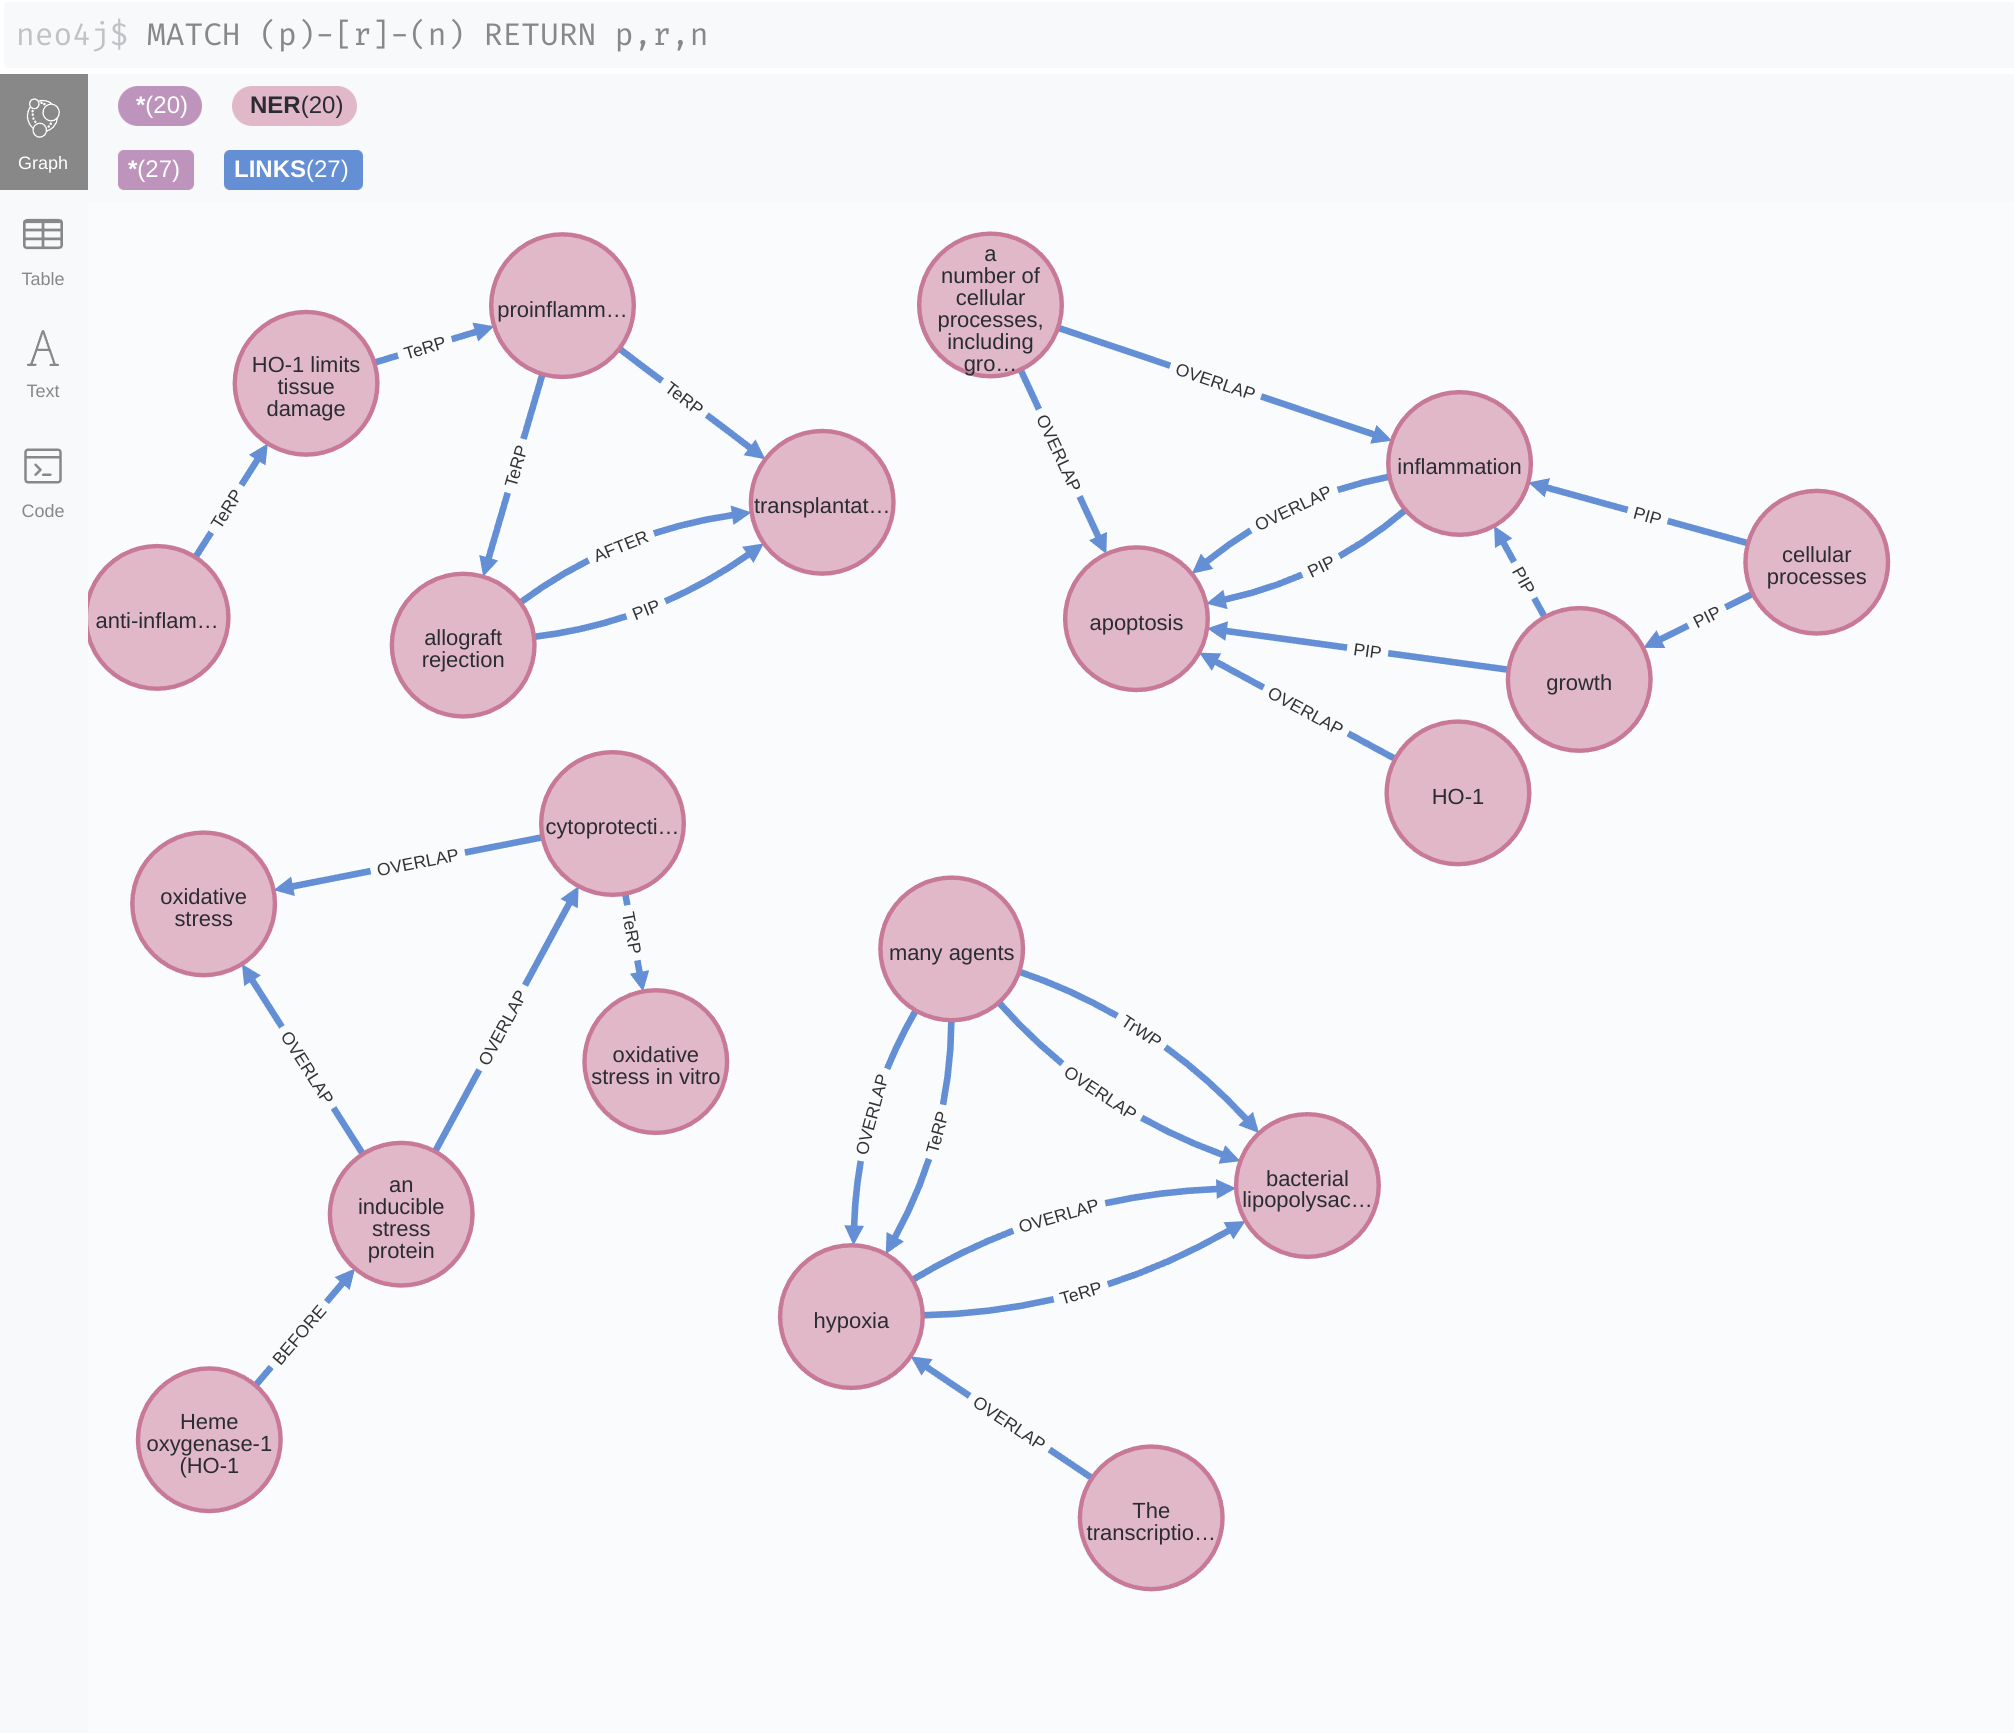

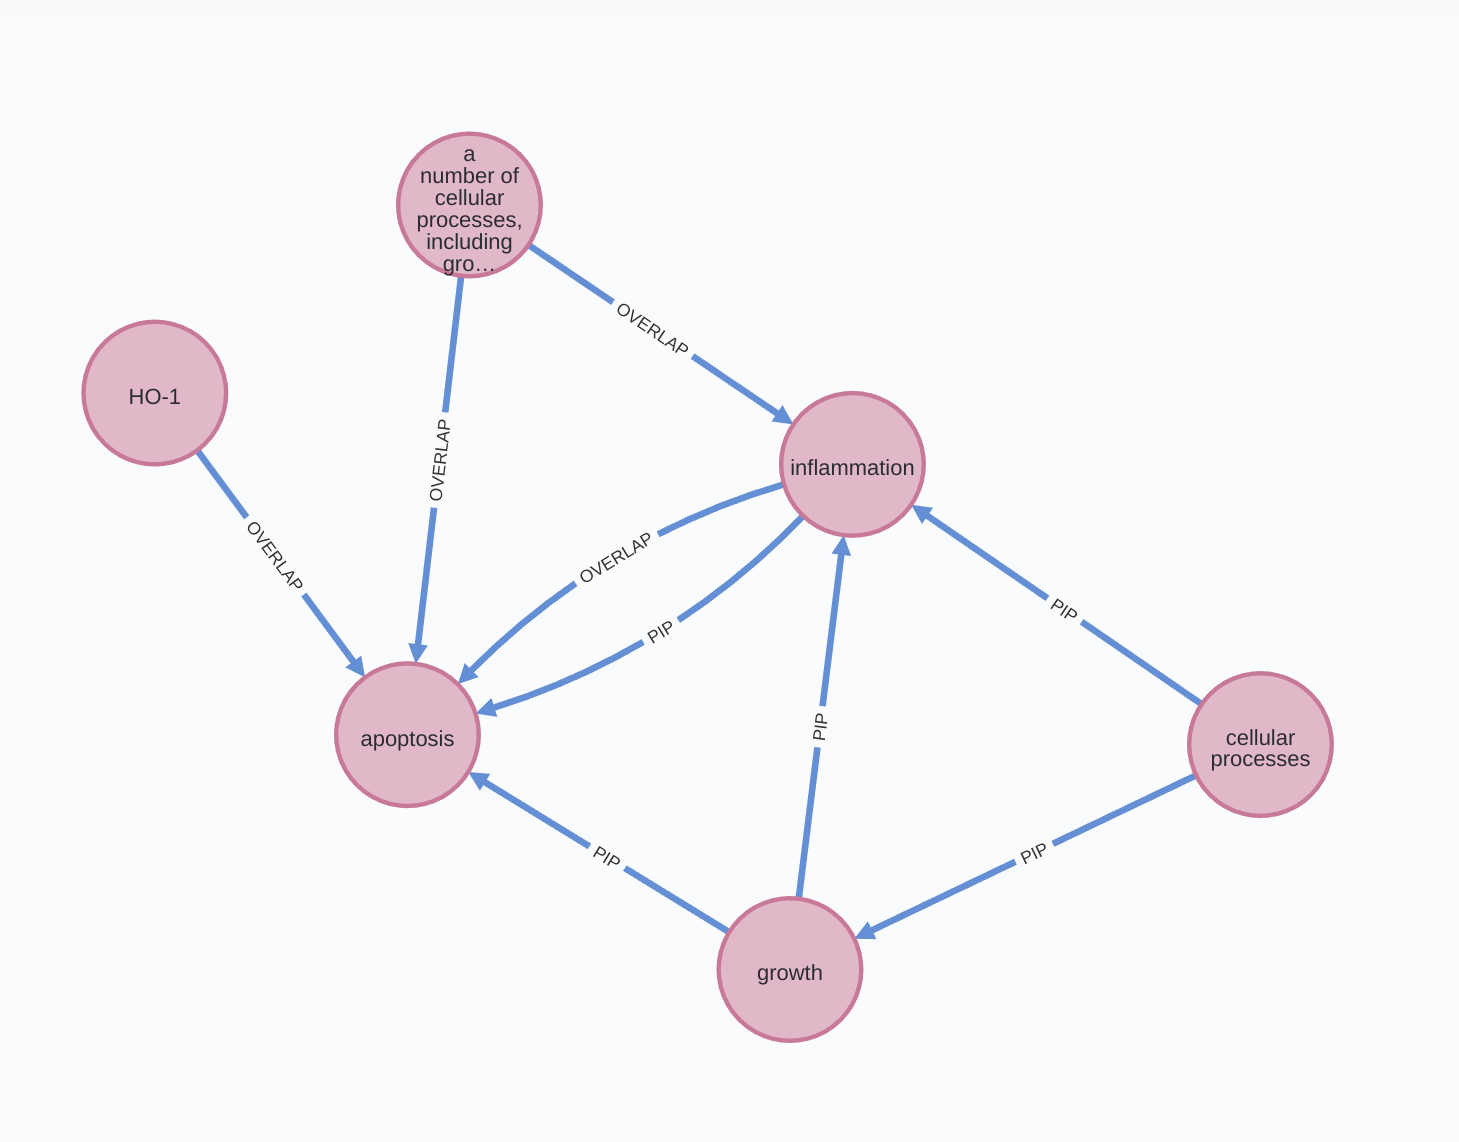

In [28]:
# Display query results
query_string = '''
MATCH (n1)-[r]-(n2) 
RETURN n1.name, n1.type, r.relation, n2.name, n2.type
'''
all_nodes_rels = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
all_nodes_rels.head()

,n1.name,n1.type,r.relation,n2.name,n2.type
0,cytoprotection,TREATMENT,TeRP,oxidative stress in vitro,PROBLEM
1,cytoprotection,TREATMENT,OVERLAP,oxidative stress,PROBLEM
2,cytoprotection,TREATMENT,OVERLAP,an inducible stress protein,PROBLEM
3,cellular processes,PROBLEM,PIP,growth,PROBLEM
4,cellular processes,PROBLEM,PIP,inflammation,PROBLEM


In [30]:
delete_all_nodes = '''
MATCH (n) WITH n LIMIT 10000
DETACH DELETE n RETURN count(*)
'''
conn.query(delete_all_nodes)

[<Record count(*)=0>]

# Neo4j KG for Articles

## Neo4j Connection and Database

Define unique constraints.

In [31]:
conn.query('CREATE CONSTRAINT articles IF NOT EXISTS ON (a:Article)  ASSERT a.index IS UNIQUE;')
conn.query('CREATE CONSTRAINT authors IF NOT EXISTS ON (a:Author) ASSERT a.author IS UNIQUE;')
conn.query('CREATE CONSTRAINT journals IF NOT EXISTS ON (j:Journal) ASSERT j.journal IS UNIQUE;')

[]

In [32]:
# Source: https://towardsdatascience.com/create-a-graph-database-in-neo4j-using-python

def add_journals(journals):
    '''
    Adds journals nodes to the Neo4j graph.
    '''
    query = '''
            UNWIND $rows AS row
            MERGE (j:Journal {journal: row.journal})
            RETURN count(*) as total
            '''
    return conn.query(query, parameters = {'rows':journals.to_dict('records')})

def add_authors(rows, batch_size=1000):
    '''
    Adds authors nodes to the Neo4j graph as a batch job.
    '''
    query = '''
            UNWIND $rows AS row
            MERGE (:Author {name: row.author})
            RETURN count(*) as total
            '''
    return update_data(query, rows, batch_size)

Add the nodes and the relationships

In [33]:
def add_papers(rows, batch_size=1000):
    
    # Adds paper nodes and
    # relationships (:Author)--(:Paper)
    # (:Paper)--(:Journal)
    # to the Neo4j graph as a batch job.
 
    query = '''
    UNWIND $rows as row
    MERGE (p:Paper {index:row.index}) ON CREATE SET p.title = row.title
 
    // connect journal
    WITH row, p
    UNWIND row.journal AS journal
    MATCH (j:Journal {journal: journal})
    MERGE (p)-[:IN_JOURNAL]->(j)

    // connect authors
    WITH distinct row, p // reduce cardinality
    UNWIND row.author AS author
    MATCH (a:Author {name: author})
    MERGE (a)-[:AUTHORED]->(p)
    RETURN count(distinct p) as total
    '''
 
    return update_data(query, rows, batch_size)

In [34]:
# Populate the dataframe
journals = pd.DataFrame(metadata_df[['journal']])
authors = pd.DataFrame(metadata_df[['author']])

add_journals(journals)
add_authors(authors)
add_papers(metadata_df)

{'total': 1000, 'batches': 1, 'time': 0.4655289649963379}
{'total': 2000, 'batches': 2, 'time': 0.5882563591003418}
{'total': 3000, 'batches': 3, 'time': 0.6655385494232178}
{'total': 4000, 'batches': 4, 'time': 0.7446813583374023}
{'total': 5000, 'batches': 5, 'time': 0.8283500671386719}
{'total': 6000, 'batches': 6, 'time': 0.9043090343475342}
{'total': 7000, 'batches': 7, 'time': 0.9838051795959473}
{'total': 8000, 'batches': 8, 'time': 1.0794596672058105}
{'total': 8088, 'batches': 9, 'time': 1.1217098236083984}
{'total': 1000, 'batches': 1, 'time': 1.3994746208190918}
{'total': 2000, 'batches': 2, 'time': 3.451655149459839}
{'total': 3000, 'batches': 3, 'time': 6.563469171524048}
{'total': 3998, 'batches': 4, 'time': 11.382272243499756}
{'total': 4998, 'batches': 5, 'time': 16.657244205474854}
{'total': 5998, 'batches': 6, 'time': 23.54552984237671}
{'total': 6998, 'batches': 7, 'time': 31.466588735580444}
{'total': 7998, 'batches': 8, 'time': 40.64504885673523}
{'total': 8086, 'b

{'batches': 9, 'time': 42.19569134712219, 'total': 8086}

In [35]:
query = '''MATCH (a:Author)-[:AUTHORED]->(p:Paper)-[:IN_JOURNAL]->(j:Journal) RETURN a, p, j LIMIT 6'''
sample_result = pd.DataFrame([dict(_) for _ in conn.query(query)])
sample_result

,a,p,j
0,(name),"(index, title)",(journal)
1,(name),"(index, title)",(journal)
2,(name),"(index, title)",(journal)
3,(name),"(index, title)",(journal)
4,(name),"(index, title)",(journal)
5,(name),"(index, title)",(journal)


## Sample Queries and Results 

In [80]:
# Inspect the dataframe
query = '''
MATCH (a:Author)-[:AUTHORED]->(p:Paper)-[:IN_JOURNAL]->(j:Journal) 
RETURN a, p, j 
LIMIT 300
'''

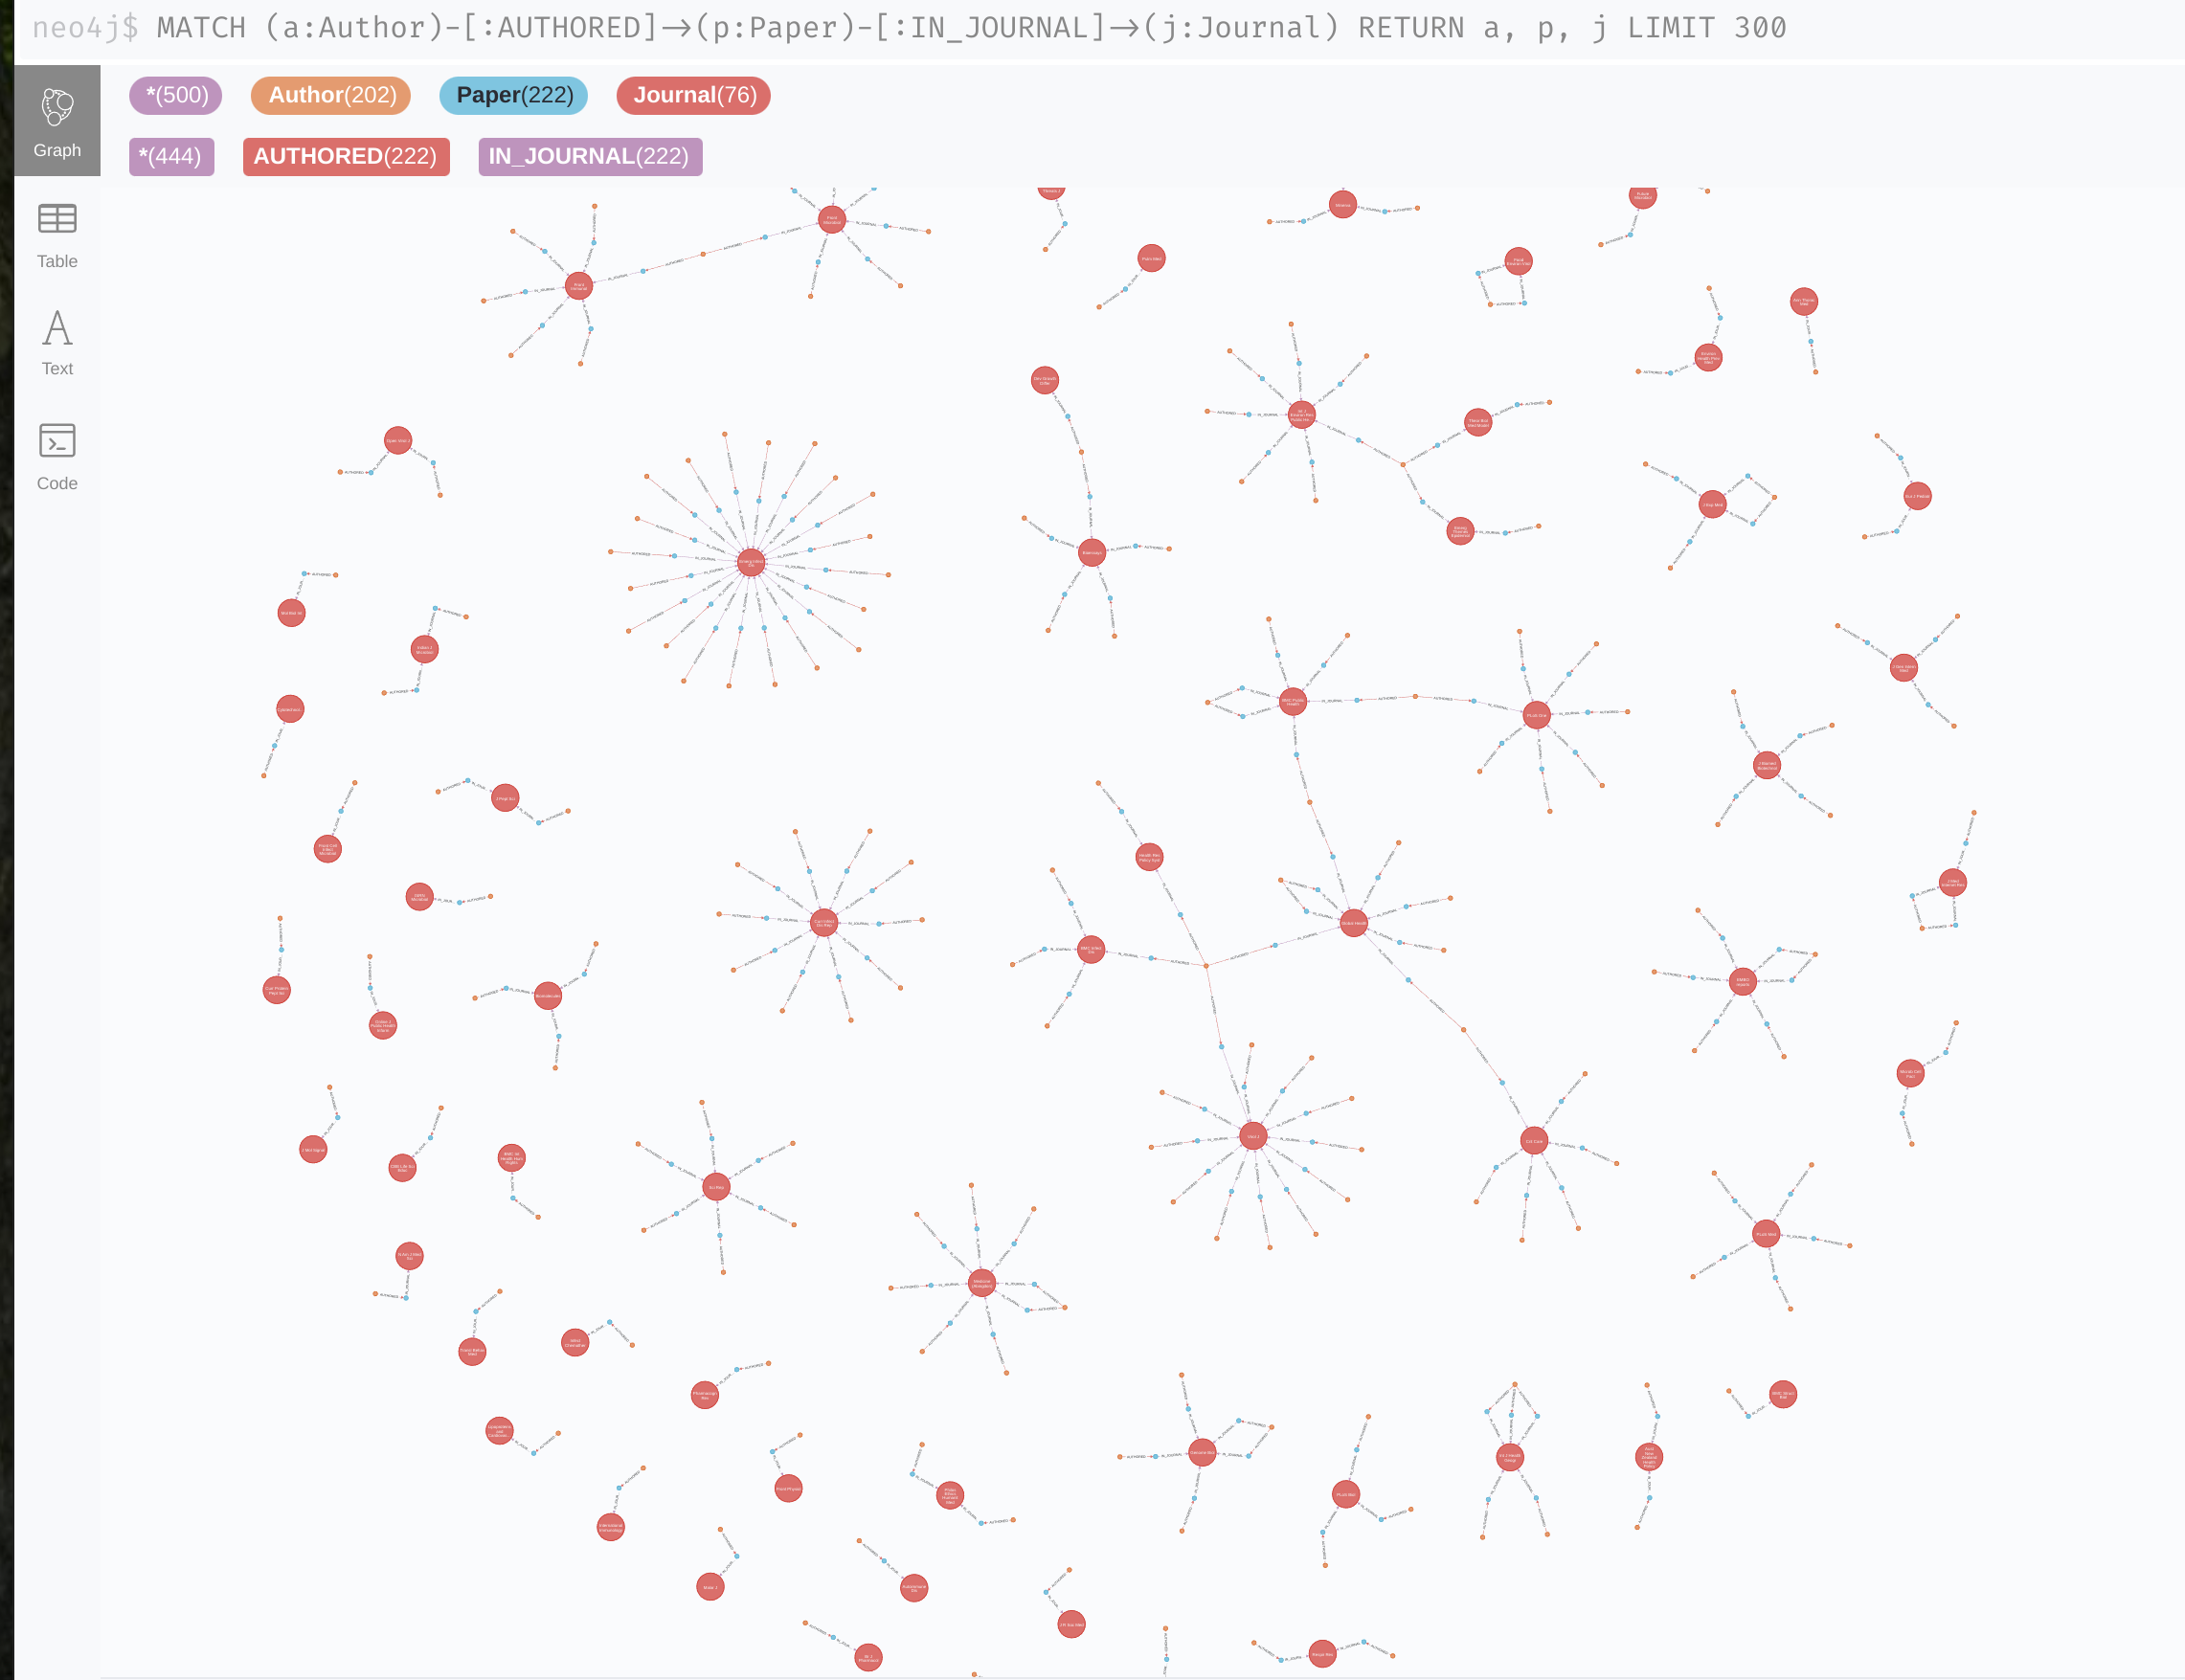

In [45]:
# Inspect the dataframe
query = '''
MATCH (a:Author)-[:AUTHORED]->(p:Paper)-[:IN_JOURNAL]->(j:Journal) RETURN a, p, j LIMIT 10
'''

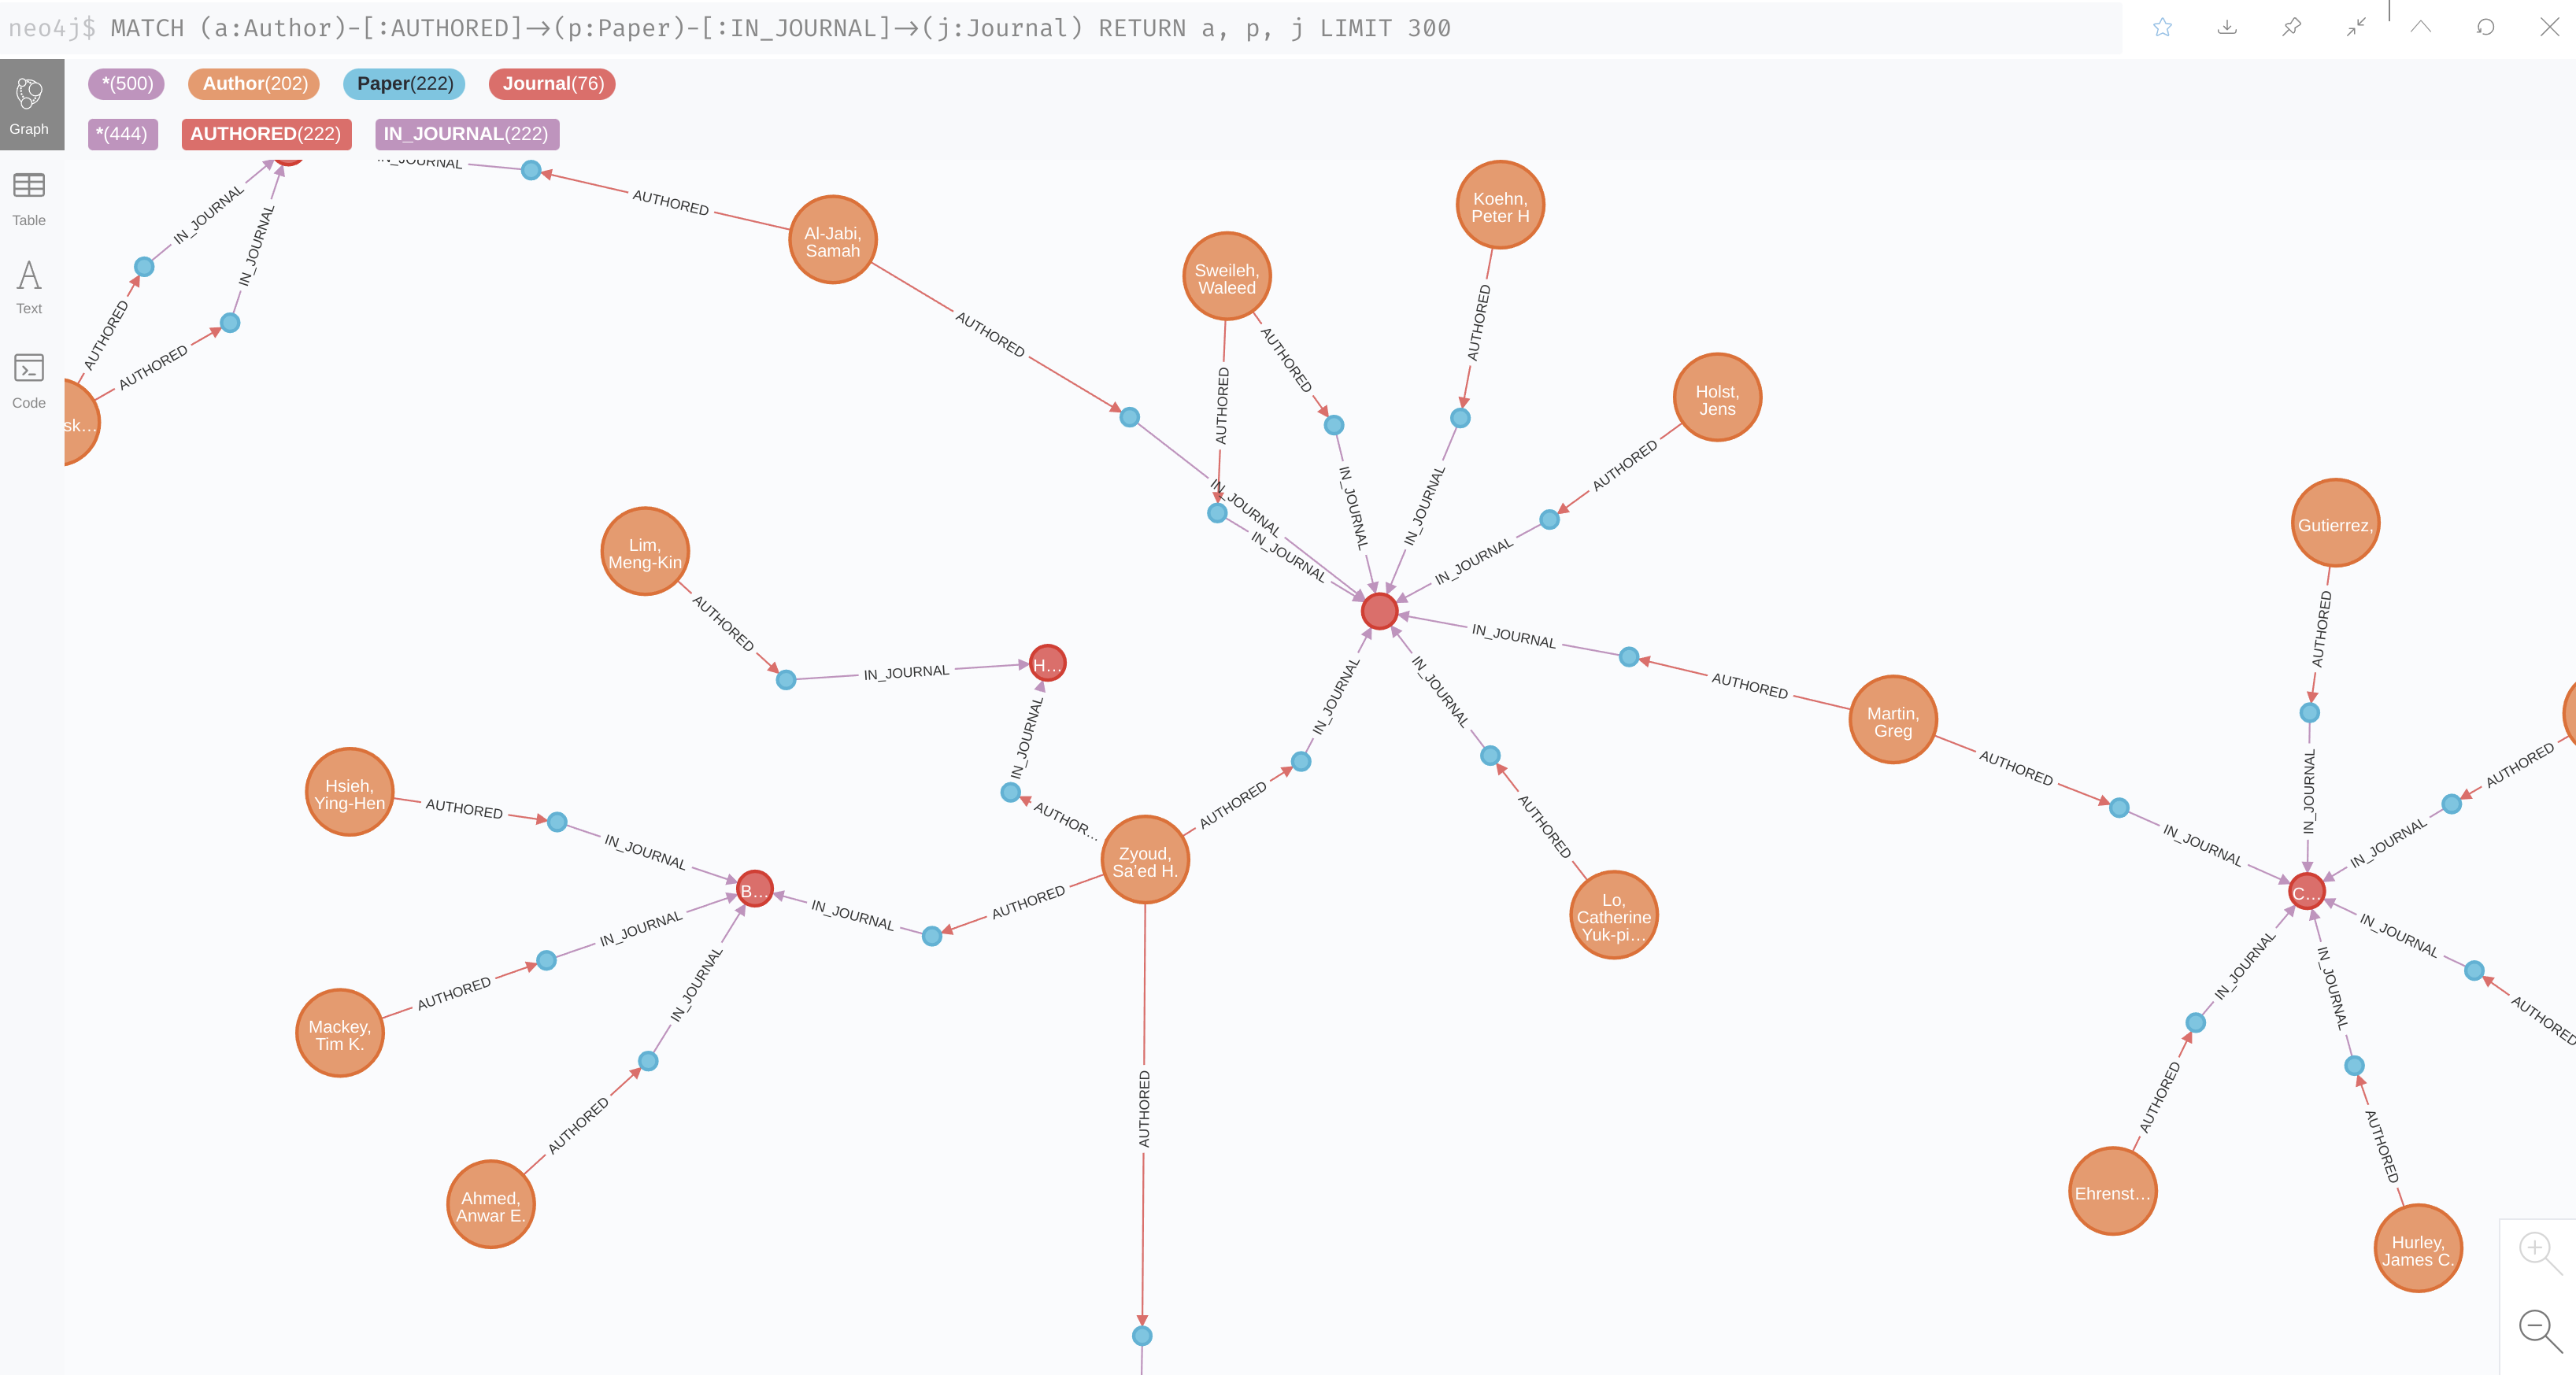

# KG with NER for Articles

In [36]:
# Extract the title column
df = metadata_df[['index','abstract']]

In [37]:
# Rename the column
df = df.rename(columns={"abstract": "text"})
df.head(2)

,index,text
2,1,Surfactant protein-D (SP-D) participates in th...
13,2,Recent analyses of human pathogens have reveal...


In [38]:
# Convert data into Spark DF
metaSparkDF = spark.createDataFrame(df)

In [41]:
# Retain the first 100 rows only
metaSparkReduced = metaSparkDF.limit(100)
metaSparkReduced.show(4, truncate=False) 

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [42]:
# Apply the pipeline model
result = merger_model.transform(metaSparkReduced)
result.show(2)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|index|                text|            document|           sentences|              tokens|          embeddings|            pos_tags|            ner_tags|          ner_chunks|        dependencies|    events_relations|        ner_clinical| clinical_ner_chunks|  clinical_relations|       all_relations|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    1|Surfactant protei...|[{document, 0, 16...|[{document, 0, 18...|[{token, 0, 9, Su...|[{w

In [43]:
# Create spark DF from metadata dataframe and limit to 100 entries
meta_spark = spark.createDataFrame(metadata_df).limit(100)
meta_spark.show(2)

+--------------------+--------------------+----------------+-----------+-----+
|               title|            abstract|          author|    journal|index|
+--------------------+--------------------+----------------+-----------+-----+
|Surfactant protei...|Surfactant protei...| Crouch, Erika C| Respir Res|    1|
|Discovering human...|Recent analyses o...|Disotell, Todd R|Genome Biol|    2|
+--------------------+--------------------+----------------+-----------+-----+
only showing top 2 rows



In [59]:
combined_sparkDF = meta_spark.join(result, meta_spark.index==result.index,"inner").drop(meta_spark.index)
combined_sparkDF.show(4)

+--------------------+--------------------+-----------------+-----------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               title|            abstract|           author|    journal|index|                text|            document|           sentences|              tokens|          embeddings|            pos_tags|            ner_tags|          ner_chunks|        dependencies|    events_relations|        ner_clinical| clinical_ner_chunks|  clinical_relations|       all_relations|
+--------------------+--------------------+-----------------+-----------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----

In [62]:
def display_results_sparkDF(df):
    '''
    Function to select and display the output of a pipeline as a spark dataframe.
    The dataframe must have column: ner_key_phrases.
    df - output of pipeline.fit(empty_df).transform(input_df)
    '''

    results_pds = df \
        .select(df.index, df.text,\
         F.explode(F.arrays_zip("all_relations.result",
                                "all_relations.metadata")).alias('cols')) \
        .select(df.index, df.text, F.expr("cols['0']").alias('relation'),
            F.expr("cols['1']['entity1']").alias("entity1"),
            F.expr("cols['1']['chunk1']").alias("chunk1"),
            F.expr("cols['1']['entity2']").alias("entity2"),
            F.expr("cols['1']['chunk2']").alias("chunk2"))

    return results_pds

In [64]:
result_re = display_results_sparkDF(result)
result_re.show(4)

+-----+--------------------+--------+---------+--------------------+-------+--------------------+
|index|                text|relation|  entity1|              chunk1|entity2|              chunk2|
+-----+--------------------+--------+---------+--------------------+-------+--------------------+
|    1|Surfactant protei...|    TrWP|TREATMENT|Surfactant protei...|PROBLEM|immune and inflam...|
|    1|Surfactant protei...|     PIP|  PROBLEM|      microorganisms|PROBLEM|    organic antigens|
|    1|Surfactant protei...|    TeRP|     TEST|                SP-D|PROBLEM|alveolar and bron...|
|    1|Surfactant protei...|    TeRP|     TEST|                SP-D|PROBLEM|epithelial cells ...|
+-----+--------------------+--------+---------+--------------------+-------+--------------------+
only showing top 4 rows



In [65]:
# Rewrite the results as a pandas dataframe
result_re_df = result_re.toPandas()

# Save the results in csv files
result_re_df.to_csv("result_full.csv")

# Download the results files
from google.colab import files
files.download("result_full.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [73]:
delete_all_nodes = '''
MATCH (n) WITH n LIMIT 10000
DETACH DELETE n RETURN count(*)
'''
conn.query(delete_all_nodes)

[<Record count(*)=0>]

In [74]:
# Provide credentials - from Sandbox page - and initiate the connection
uri = 'bolt://44.201.183.12:7687'
pwd = 'fault-fact-whistles'
user= 'neo4j'

conn = Neo4jConnection(uri=uri, user=user , pwd=pwd)

In [75]:
const_ners = 'CREATE CONSTRAINT ners IF NOT EXISTS ON (n:NER) ASSERT n.name IS UNIQUE'
conn.query(const_ners)

[]

In [76]:
add_ners_rels(result_re_df)

{'total': 2260, 'batches': 1, 'time': 1.3869609832763672}


{'batches': 1, 'time': 1.3869609832763672, 'total': 2260}

In [77]:
query_string = '''MATCH (n1)-[r]-(n2)
RETURN n1.name, n1.type, r.relation, n2.name, n2.type'''

In [78]:
all_nodes_rels = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
all_nodes_rels.head(10)

,n1.name,n1.type,r.relation,n2.name,n2.type
0,Surfactant protein-D (SP-D,TREATMENT,TrWP,immune and inflammatory regulation within the ...,PROBLEM
1,microorganisms,PROBLEM,PIP,organic antigens,PROBLEM
2,microorganisms,PROBLEM,OVERLAP,oligosaccharides,PROBLEM
3,microorganisms,PROBLEM,TeRP,surface glycoconjugates,TEST
4,microorganisms,PROBLEM,PIP,oligosaccharides,PROBLEM
5,microorganisms,PROBLEM,OVERLAP,surface glycoconjugates,TEST
6,SP-D,TEST,OVERLAP,glycoconjugates,PROBLEM
7,SP-D,TEST,TeRP,alveolar and bronchiolar epithelial cells,PROBLEM
8,SP-D,TEST,TeRP,lymphocytes,TREATMENT
9,SP-D,TEST,TeRP,epithelial cells lining various exocrine ducts,PROBLEM


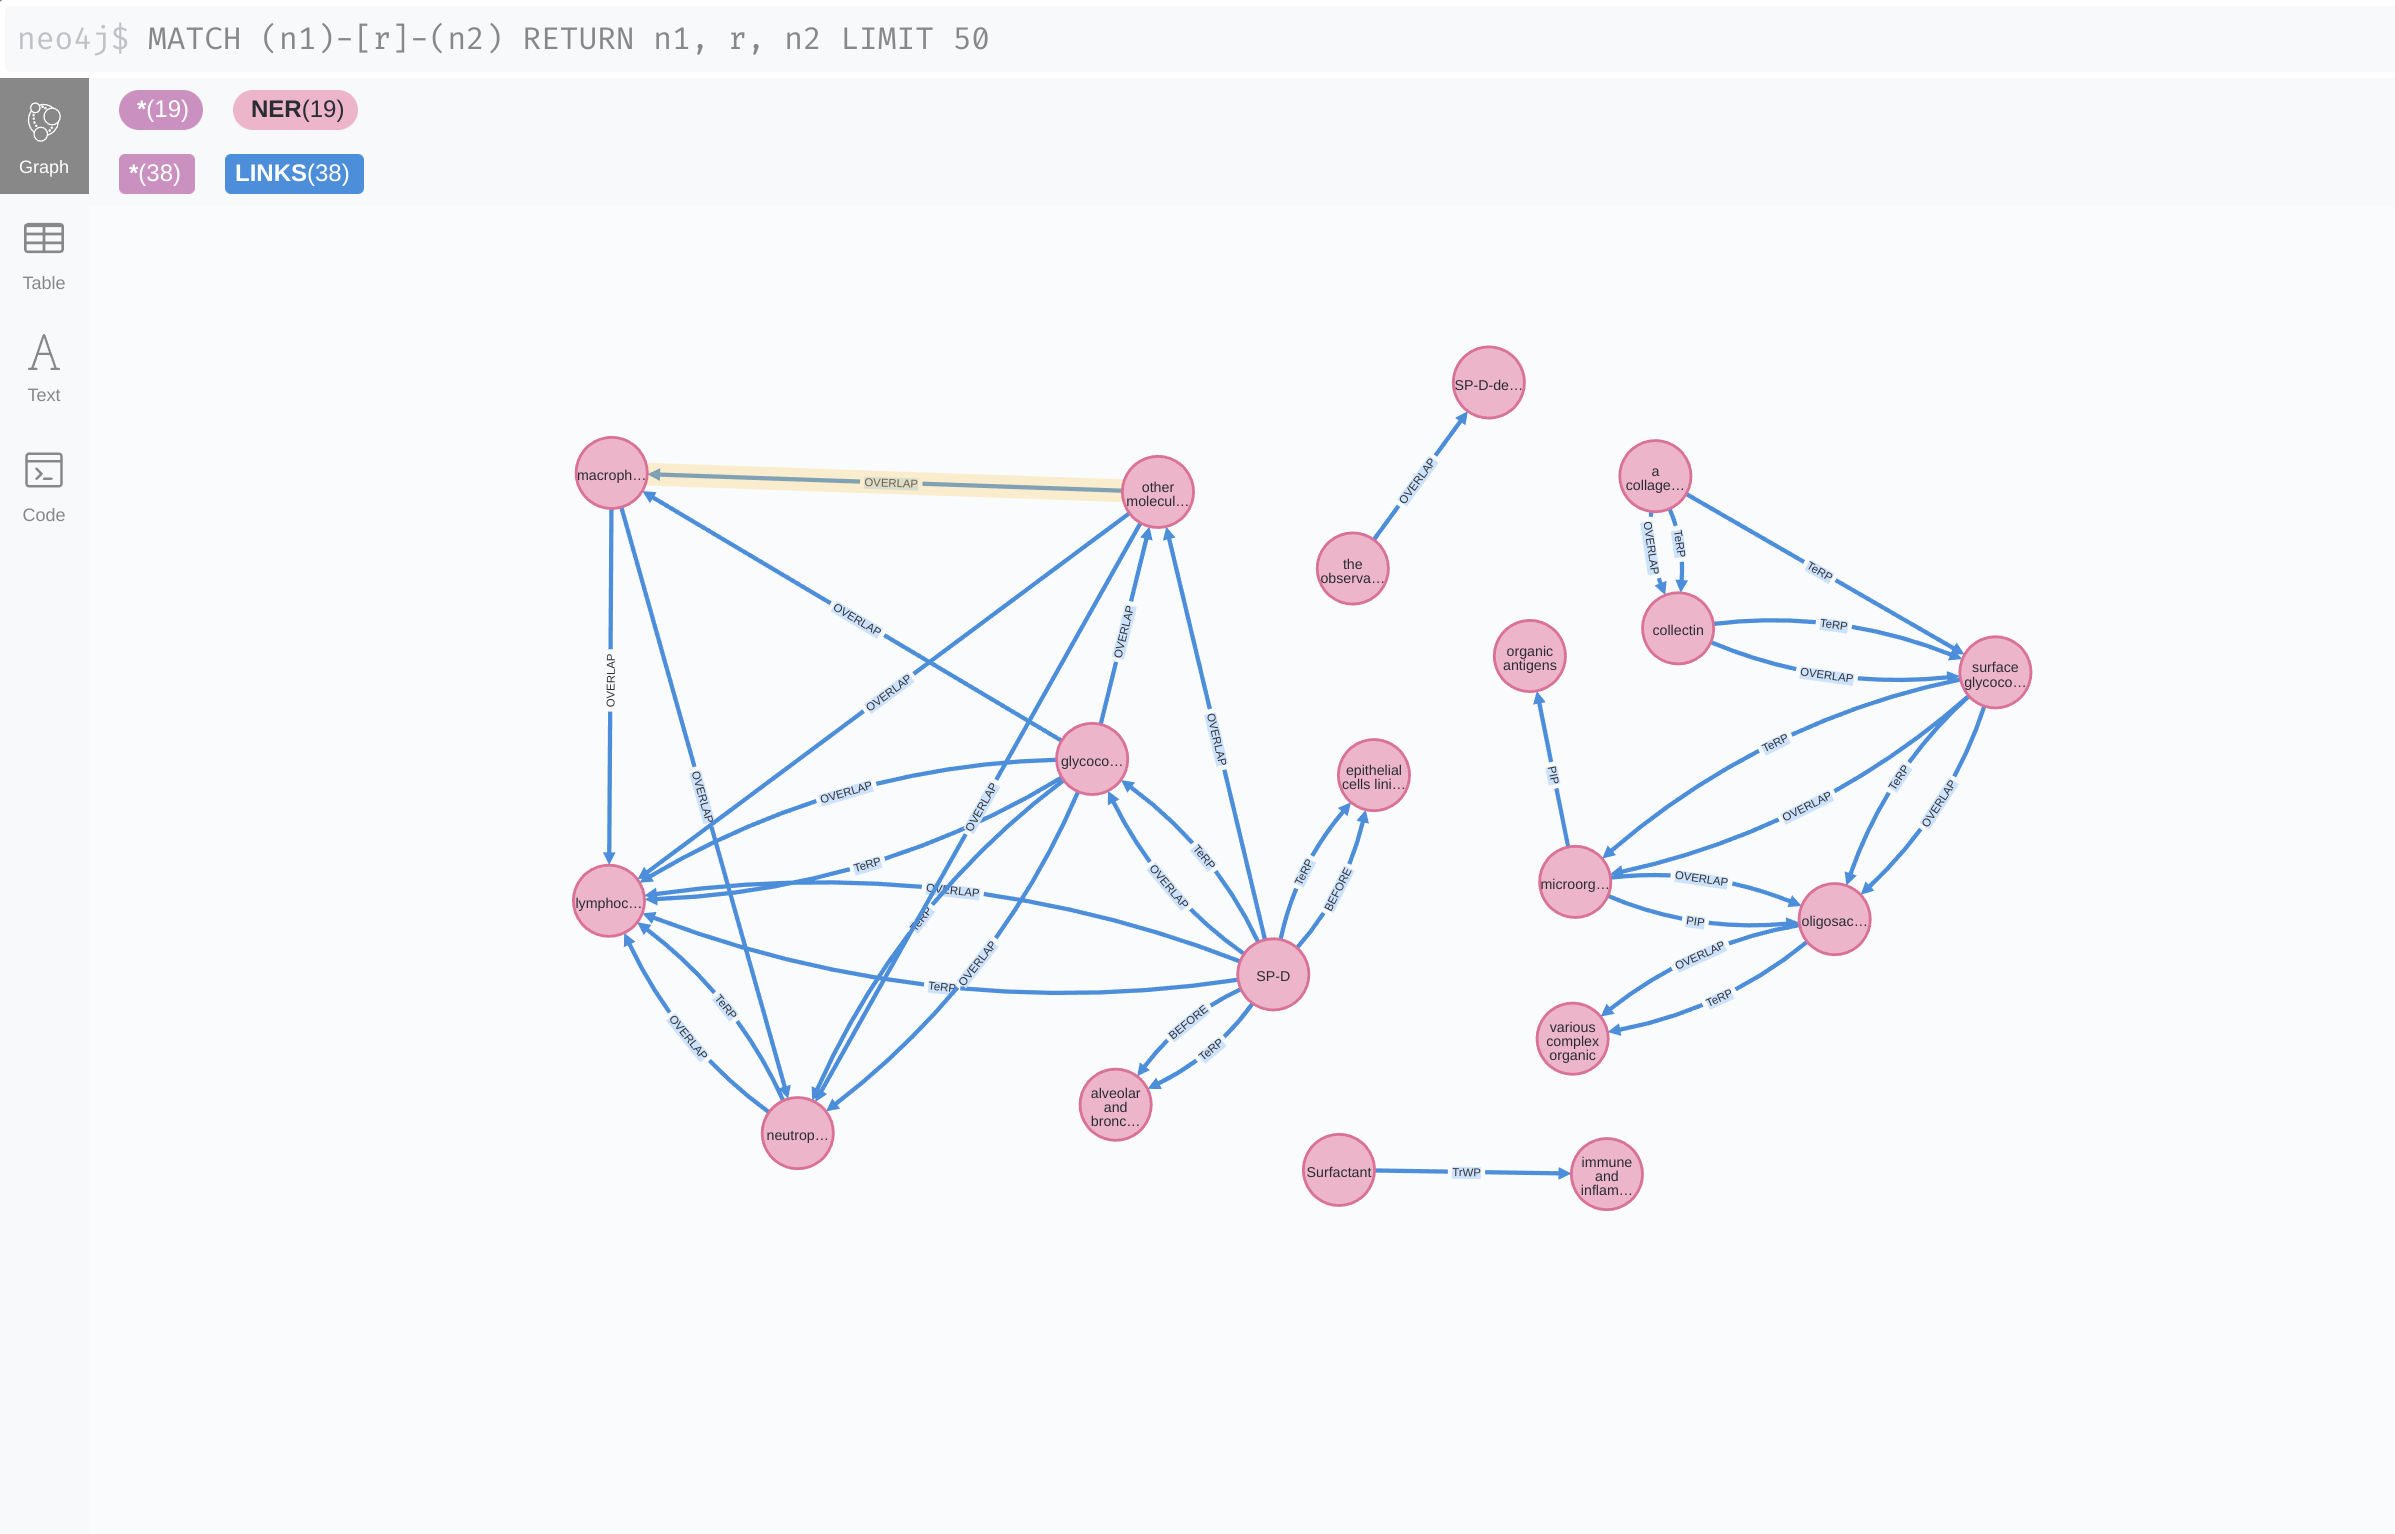